## Training

In this notebook, we will carry out hyperparameter tuning to find a good Latent Dirichlet Allocation (LDA) model.

In [23]:
# imports
import os
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, "../")
from dataset import ArXivDataset
from model import TopicModel
from gensim.models import LdaModel, CoherenceModel
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns

sns.set_context("talk")
sns.set_style("ticks")
%config InlineBackend.figure_format="retina"

### Load dataset

While this notebook loads an already built and processed dataset or arXiv papers, a new dataset can be built and prepared using `ArXivDataset.from_metadata(...)`. See `dataset.py` for more details.

In [24]:
# load dataset
dataset_path = "../object/dataset.obj"
dataset = ArXivDataset.load(dataset_path)
print("# papers: {s}".format(s=len(dataset)))

# papers: 237


### Hyperparameter tuning

Now that we have loaded up the dataset, the next step is to train LDA models using a variety of hyperparameter combinations. For this particular dataset, I noticed that setting the number of topics to around 12-15 tends to yield the best results. The number of passes (epochs) will be fixed at a value of 5.

In [25]:
number_of_topics = 40
num_topics_list = []
for i in range(1,number_of_topics):
    num_topics_list.append(i)
    

In [26]:
# set hyperparameters
number_of_topics = 40
num_topics_list = []
for i in range(1,number_of_topics):
    num_topics_list.append(i)
num_passes = 10
random_state = 929

In [27]:
# run grid search
model_list = []
score_list = []
for num_topics in num_topics_list:
    model = LdaModel(corpus=dataset.corpus, id2word=dataset.idx2word,
                     num_topics=num_topics, passes=num_passes,
                     random_state=random_state, per_word_topics=True)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=dataset.documents,
                                     dictionary=dataset.idx2word, coherence="c_v")
    score = coherence_model.get_coherence()
    score_list.append(score)
    print(" * num_topics: {n:02d}\tscore: {s:.3f}".format(n=num_topics, s=score))

 * num_topics: 01	score: 0.304
 * num_topics: 02	score: 0.347
 * num_topics: 03	score: 0.335
 * num_topics: 04	score: 0.340
 * num_topics: 05	score: 0.323
 * num_topics: 06	score: 0.313
 * num_topics: 07	score: 0.330
 * num_topics: 08	score: 0.321
 * num_topics: 09	score: 0.301
 * num_topics: 10	score: 0.313
 * num_topics: 11	score: 0.328
 * num_topics: 12	score: 0.323
 * num_topics: 13	score: 0.330
 * num_topics: 14	score: 0.313
 * num_topics: 15	score: 0.366
 * num_topics: 16	score: 0.334
 * num_topics: 17	score: 0.316
 * num_topics: 18	score: 0.333
 * num_topics: 19	score: 0.325
 * num_topics: 20	score: 0.358
 * num_topics: 21	score: 0.326
 * num_topics: 22	score: 0.366
 * num_topics: 23	score: 0.348
 * num_topics: 24	score: 0.350
 * num_topics: 25	score: 0.366
 * num_topics: 26	score: 0.377
 * num_topics: 27	score: 0.345
 * num_topics: 28	score: 0.377
 * num_topics: 29	score: 0.361
 * num_topics: 30	score: 0.346
 * num_topics: 31	score: 0.379
 * num_topics: 32	score: 0.325
 * num_t

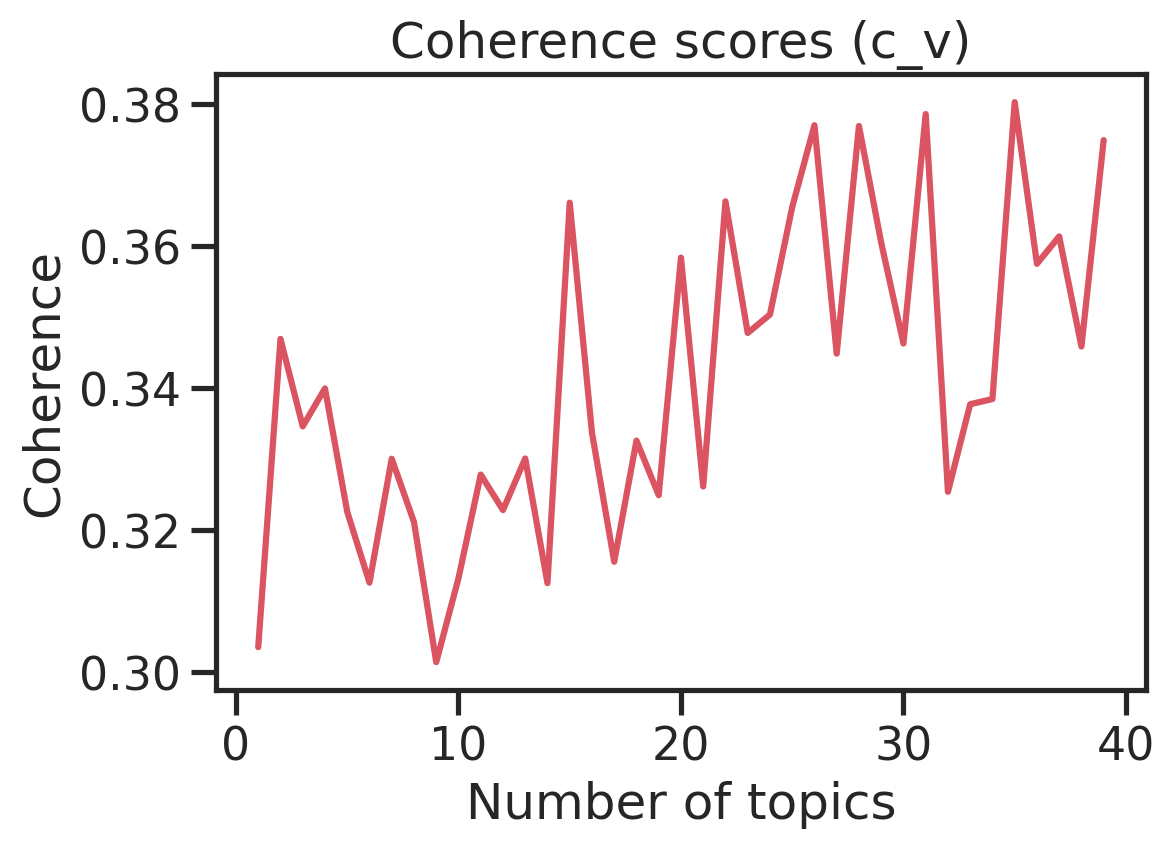

In [28]:
# plot coherence scores
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_title("Coherence scores (c_v)")
sns.lineplot(x=num_topics_list, y=score_list, color="#DB5461", 
             ax=ax, legend=False)
ax.set_xlabel("Number of topics")
ax.set_ylabel("Coherence")
plt.show()


From the above plot, it can be observed that setting the number of topics to be 12 would be optimal.

### Exporting the best model

Now that we have identified the best model, we can export it for inference in the future.

In [29]:
# export best model
best_idx = np.argmax(score_list)
best_model = model_list[best_idx]
best_score = score_list[best_idx]
num_topics = num_topics_list[best_idx]
best_model_path = "../models/lda_n{n}_p{p}_r{r}_c{c}".format(n=num_topics, p=num_passes,
                                                            r=random_state,
                                                            c=str(round(best_score * 100, 1)))
best_model.save(best_model_path)
print("Model saved to {path}".format(path=best_model_path))

Model saved to ../models/lda_n35_p10_r929_c38.0


In [32]:
# create topic model
model_path = best_model_path
dataset_path = "../object/dataset.obj"
model = TopicModel(model_path, dataset_path)

In [ ]:
# print topics
pprint(model.topics)